In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Работа с нерепрезентативными данными

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/tixonsit/mmdad_materials/master/datasets_14872_228180_Admission_Predict_Ver1.1.csv')
del df['Serial No.']

In [ ]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [ ]:
len(df)

500

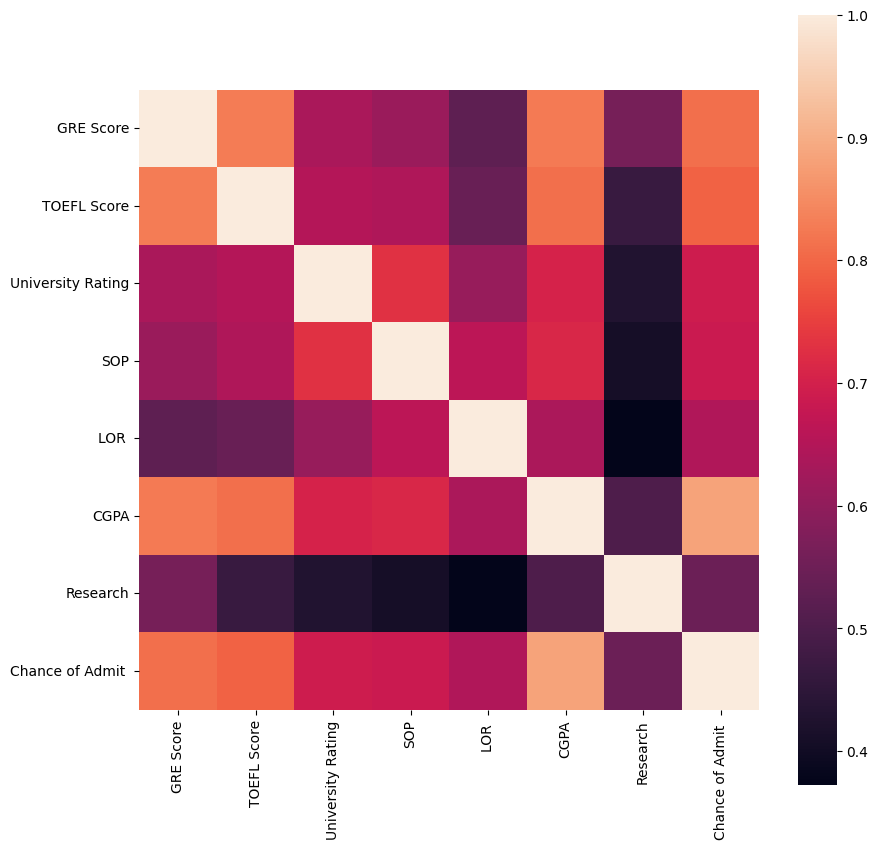

In [ ]:
import seaborn as sns

plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), square=True)
plt.show()

## Нерепрезентативность данных

### Разная перемешка

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

$$R^2 = 1 - \frac{\sum_i (y_i-\hat{y_i})^2}{\sum_i (y_i-\bar{y})^2}, \quad \bar{y} = \frac{1}{N} \sum_i y_i$$


In [ ]:
# массив результатов
r2_shuffles = []

# проверим, зависит ли изначальная перемешка от результата
for i in range(20):
    # перемешка
    df = df.sample(frac=1).reset_index(drop=True)

    # train test split
    df_train = df[:400]
    df_test = df[400:]

    # среднее и стандартное отклонение
    mean = df_train.mean(axis=0)
    std = df_train.std(axis=0)

    # стандартизация
    df_train = (df_train - mean) / std
    X_train = df_train.drop(columns=['Chance of Admit ']).values
    y_train = df_train['Chance of Admit '].values
    df_test = (df_test - mean) / std
    X_test = df_test.drop(columns=['Chance of Admit ']).values
    y_test = df_test['Chance of Admit '].values

    alg = Ridge()
    alg.fit(X_train, y_train)
    print(f'Итерация {i+1} | R^2 = ', r2_score(y_test, alg.predict(X_test)))

    r2_shuffles.append(r2_score(y_test, alg.predict(X_test)))

Итерация 1 | R^2 =  0.8607142105926038
Итерация 2 | R^2 =  0.8759986709838645
Итерация 3 | R^2 =  0.8541486547796764
Итерация 4 | R^2 =  0.8441087823537292
Итерация 5 | R^2 =  0.7325238938889931
Итерация 6 | R^2 =  0.8388130258066384
Итерация 7 | R^2 =  0.7383194987941739
Итерация 8 | R^2 =  0.8075016167909506
Итерация 9 | R^2 =  0.8343745601440253
Итерация 10 | R^2 =  0.8128493288385863
Итерация 11 | R^2 =  0.8187837482471364
Итерация 12 | R^2 =  0.8235781249472082
Итерация 13 | R^2 =  0.825778986761893
Итерация 14 | R^2 =  0.8245492978297527
Итерация 15 | R^2 =  0.8265378947720924
Итерация 16 | R^2 =  0.7957886100600903
Итерация 17 | R^2 =  0.8519103015335889
Итерация 18 | R^2 =  0.8014890773082595
Итерация 19 | R^2 =  0.8315640118653096
Итерация 20 | R^2 =  0.7503984848840395


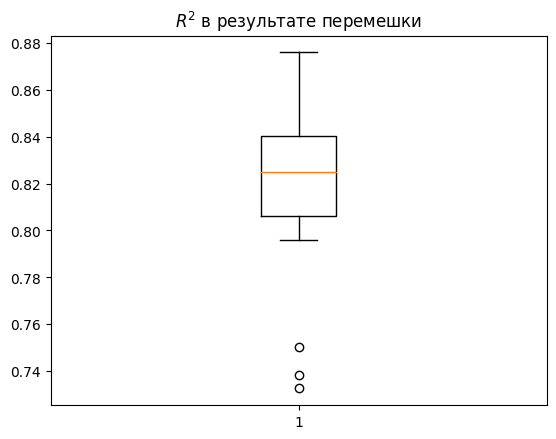

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title(r'$R^2$ в результате перемешки')
ax1.boxplot(r2_shuffles)
fig1.show()

Как еще можно обнаружить, что данных слишком мало? - Кривые обучения
Кроме этого попробуем улучшить картину от недостаточного качества путем создания новых, полиномиальных, признаков

### Кривые обучения

Изменяем размер имеющейся обучающей выборки и смотрим, как качество решения задачи зависит от объема данных, на котором мы обучали модель.Такой подход называется кривыми обучения (sklearn.model_selection.learning_curve).

Алгоритм выполняет перекрестную проверку тренировочных и тестовых показателей для разных размеров учебных наборов.
- Генератор перекрестной проверки разделяет весь набор данных $k$ раз в данных обучения и теста
- Подмножества обучающего набора с различными размерами будут использоваться для обучения модели, а для каждого размера обучающего подмножества и набора тестов будут вычисляться метрики
- После этого результаты будут усреднены по всем $k$ прогонам для каждого размера подмножества тренировки.

Таким образом в результате обучения у нас получится значения метрики качества по y и размер выборки по x. На них будет отображены кривые по кросс валидации и обучению.

In [ ]:
# отобразим данные и средние значения кривых между ними (так как берем k фолдов)
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
    facecolor=lines[0].get_color(), alpha=0.2)

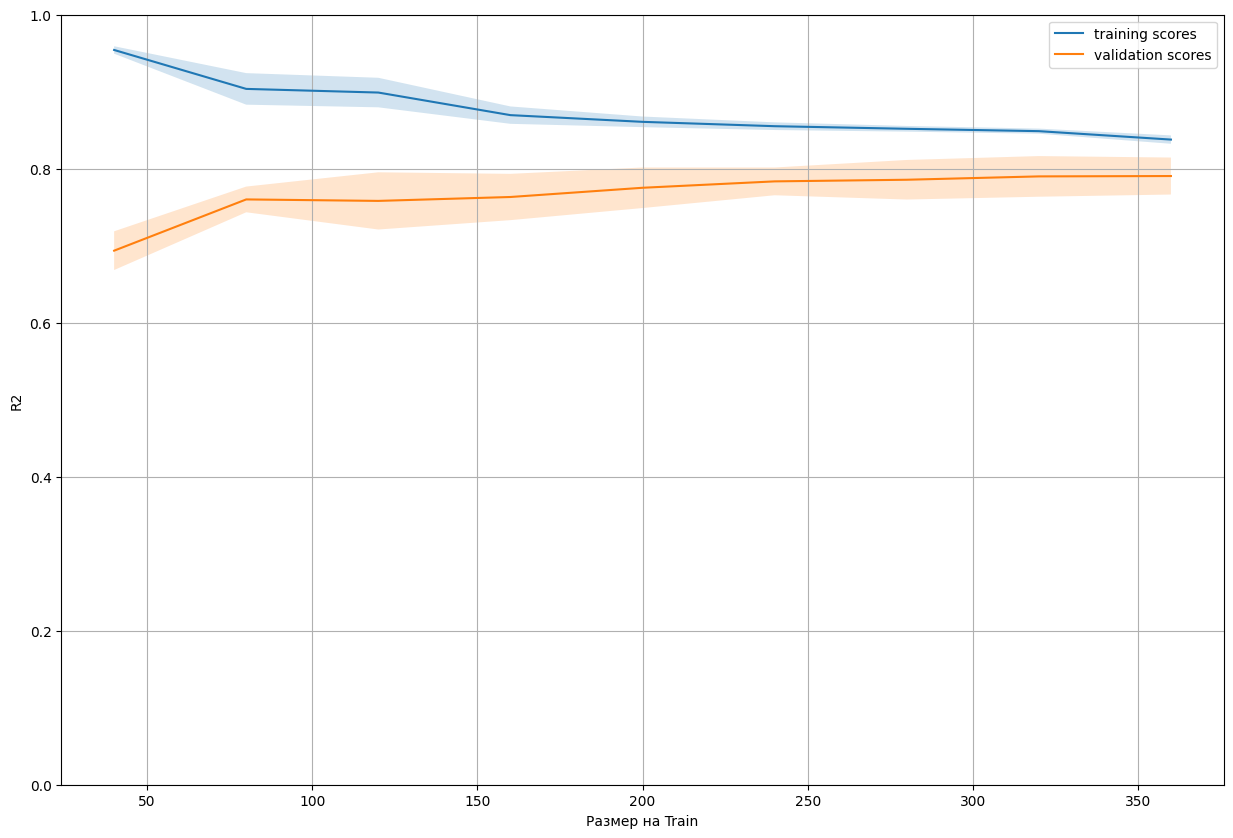

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# перемешка
df = df.sample(frac=1).reset_index(drop=True)

# train test split
df_train = df[:400]
df_test = df[400:]

# # среднее и стандартное отклонение
# mean = df.mean(axis=0)
# std = df.std(axis=0)
# # 0 мат ожидание и 1 дисперсию
# df_train = (df_train - mean)/std
# X_train = df_train.drop(columns=['Chance of Admit ']).values
# y_train = df_train['Chance of Admit '].values
# df_test = (df_test - mean)/std
# X_test = df_test.drop(columns=['Chance of Admit ']).values
# y_test = df_test['Chance of Admit '].values

pipe = Pipeline([
    ('scaler', StandardScaler()),  # нормализуем
    ('poly', PolynomialFeatures(degree=2)),  # создадим полиномиальных признаков (степень 2)
    ('alg', Ridge())  # все та же линейная с ridge регуляризация
])

N_train, val_train, val_test = learning_curve(
    pipe,
    df.drop(columns=['Chance of Admit ']).values,  # X
    df['Chance of Admit '].values,  # y
    train_sizes = np.linspace(0.1, 0.9, 9),  # переменный размер обучающей выборки
    cv=5,  # 5 фолдов кросс вал
    scoring='r2'  # R2
)

# from matplotlib.pyplot import figure, ylim
plt.figure(figsize=(15, 10))
plt.grid()
plt.ylim(0, 1)
plot_with_err(N_train, val_train, label='training scores')
plot_with_err(N_train, val_test, label='validation scores')
plt.xlabel('Размер на Train')
plt.ylabel('R2')
plt.legend()
plt.show()

* Если две кривые распологаются близко, и обе ошибки велики, — это признак недообучения
* Если две кривые далеко друг от друга — это показатель переобучения, данные нерепрезентативны
* Если кривые еще не сошлись, добавление новых данных может улучшить результат


## Аугментация

Мы попробовали аугментировать с помощью sklearn, теперь воспользуемся библиотекой [imblearn](https://imbalanced-learn.org/stable/user_guide.html):

In [ ]:
from imblearn.under_sampling import TomekLinks

In [ ]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [ ]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
import seaborn as sns

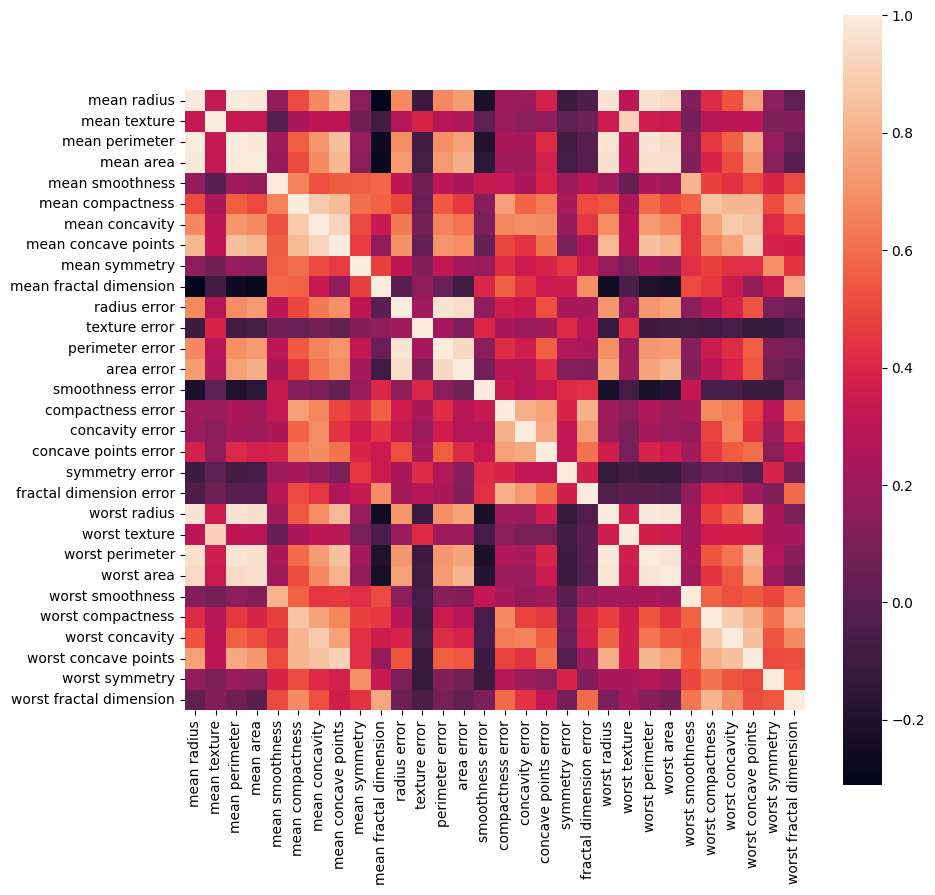

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(X.corr(), square=True)
plt.show()

In [ ]:
pd.Series(y).value_counts()

,count
1,357
0,212


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
len(y_test), len(y_train)

(114, 455)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    # class_weight = 'balanced'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        42
           1       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



### Over-sampling, Under-sampling

Существуют две стратегии реcэмплинга данных:
* добавить данных в меньший класс (oversampling)
* удалить данные из большего класса (undersampling)

В домашнем задании мы как раз удаляли случайным образом данные из большего класса.

![dssmall](https://habrastorage.org/getpro/habr/post_images/ef1/7fd/7b5/ef17fd7b511aa0ae67d398b3205068b8.png)

### Under-sampling

#### TomekLinks

Пусть примеры $E_i$ и $E_j$ принадлежат к различным классам, $d(Ei,Ej)$ – расстояние между указанными примерами. Пара $(Ei,Ej)$ называется связью Томека, если не найдется ни одного примера $E_l$ такого, что будет справедлива совокупность неравенств:

$$\begin{cases}
{d(E_i, E_l)< d(E_i, E_j)}\\
{d(E_j, E_l)< d(E_i, E_j)}
\end{cases}
$$

Согласно данному подходу, все мажоритарные записи, входящие в связи Томека, должны быть удалены из набора данных. Этот способ хорошо удаляет записи, которые можно рассматривать в качестве «зашумляющих».


![dssmall](https://habrastorage.org/getpro/habr/post_images/39c/0f9/4cb/39c0f94cbe7ea3162713d0b00fac912b.png)

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
from imblearn.under_sampling import TomekLinks

augm = TomekLinks(sampling_strategy='majority')
X_train_augm, y_train_augm = augm.fit_resample(np.array(X_train), np.array(y_train))

In [ ]:
pd.Series(y_train).value_counts()

,count
1,286
0,169


In [ ]:
pd.Series(y_train_augm).value_counts()

,count
1,275
0,169


In [ ]:
clf = LogisticRegression(class_weight = 'balanced')

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train_augm, y_train_augm)

predictions = clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### Oversampling

#### SMOTE и ADASYN

SMOTE (Synthetic Minority Over-sampling Technique)

ADASYN (Adaptive Synthetic Sampling)

![](https://hsto.org/getpro/habr/post_images/c57/e7e/f4f/c57e7ef4f8711ad2eda881651a027867.png)

**Идея** - генерация некоторого количества искусственных примеров, которые были бы «похожи» на имеющиеся в миноритарном классе, но при этом не дублировали их.

Для создания новой записи находят разность $$d = X_b – X_a,$$ где $X_a$,$X_b$ – векторы признаков «соседних» примеров $a$ и $b$ из миноритарного класса. Их находят, используя алгоритм ближайшего соседа (KNN). В данном случае необходимо и достаточно для примера $b$ получить набор из $k$ соседей, из которого в дальнейшем будет выбрана запись $b$. Остальные шаги алгоритма KNN не требуются.

Далее из $d$ путем умножения каждого его элемента на случайное число в интервале (0, 1) получают $\widehat{d}$. Вектор признаков нового примера вычисляется путем сложения $X_a$ и $\widehat{d}$. Алгоритм SMOTE позволяет задавать количество записей, которое необходимо искусственно сгенерировать. Степень сходства примеров $a$ и $b$ можно регулировать путем изменения значения $k$ (числа ближайших соседей). На рисунке схематично изображено то, как в двумерном пространстве признаков могут располагаться искусственно сгенерированные примеры.

![dssmall](https://basegroup.ru/sites/default/files/article_img/smote.gif)

Данный подход имеет недостаток в том, что «вслепую» увеличивает плотность примерами в области слабо представленного класса. В случае, если миноритарные примеры равномерно распределены среди мажоритарных и имеют низкую плотность, алгоритм SMOTE только сильнее перемешает классы.

![dssmall](https://basegroup.ru/sites/default/files/article_img/smote_overgeneralization.gif)

In [ ]:
pd.Series(y_train).value_counts()

,count
1,285
0,170


In [ ]:
from imblearn.over_sampling import ADASYN

augm = ADASYN()
X_train_augm, y_train_augm = augm.fit_resample(np.array(X_train), np.array(y_train))

In [ ]:
pd.Series(y_train_augm).value_counts()

,count
0,287
1,285


In [ ]:
clf = LogisticRegression()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train_augm, y_train_augm)

predictions = clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91        42
           1       0.97      0.92      0.94        72

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



# Пример на других данных

https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/code?datasetId=54339&sortBy=voteCount

In [ ]:
!gdown 1a6Nv0NrZfJHfuyC3GO5afm6BrjpGnyHC
!gdown 1ka0jrpPL8dAagp2Sm27UKRR6Wk5c383S

Downloading...
From: https://drive.google.com/uc?id=1a6Nv0NrZfJHfuyC3GO5afm6BrjpGnyHC
To: /content/HAM10000_metadata.csv
100% 563k/563k [00:00<00:00, 8.10MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ka0jrpPL8dAagp2Sm27UKRR6Wk5c383S
To: /content/hmnist_28_28_RGB.csv
100% 91.8M/91.8M [00:03<00:00, 29.9MB/s]


In [ ]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

df = pd.read_csv('HAM10000_metadata.csv')
df['dx'].value_counts()

,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


In [ ]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [ ]:
df.dx.value_counts()

,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


In [ ]:
pixels = pd.read_csv('hmnist_28_28_RGB.csv')
pixels

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0


In [ ]:
pixels.label.value_counts()

,count
label,
4,6705
6,1113
2,1099
1,514
0,327
5,142
3,115


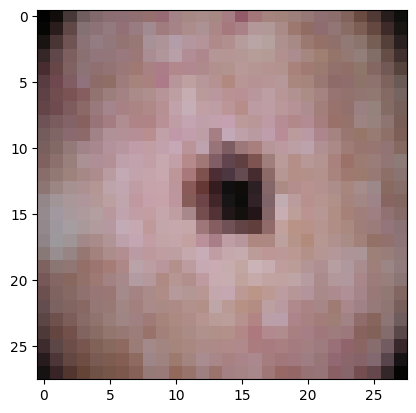

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(pixels.iloc[150,:-1].values.reshape(28, 28, 3))

In [ ]:
y = pixels.iloc[:,-1].values
X = pixels.iloc[:,:-1].values/255.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

clf = make_pipeline(
    StandardScaler(),
    SVC()
)

clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [ ]:
preds = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.35      0.12      0.18        65
           1       0.54      0.42      0.47       103
           2       0.55      0.36      0.43       220
           3       0.00      0.00      0.00        23
           4       0.76      0.97      0.86      1341
           5       0.00      0.00      0.00        28
           6       0.69      0.16      0.26       223

    accuracy                           0.73      2003
   macro avg       0.41      0.29      0.31      2003
weighted avg       0.69      0.73      0.68      2003



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
import numpy as np

# augm = ADASYN()
augm = TomekLinks(sampling_strategy='majority')
X_train_augm, y_train_augm = augm.fit_resample(np.array(X_train), np.array(y_train))

In [ ]:
pd.Series(y_train_augm).value_counts()

,count
4,5252
6,890
2,879
1,411
0,262
5,114
3,92


In [ ]:
clf = make_pipeline(
    StandardScaler(),
    SVC()
)

clf.fit(X_train_augm, y_train_augm)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [ ]:
preds = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.38      0.14      0.20        65
           1       0.52      0.42      0.46       103
           2       0.53      0.37      0.43       220
           3       0.00      0.00      0.00        23
           4       0.77      0.97      0.86      1341
           5       0.00      0.00      0.00        28
           6       0.69      0.17      0.27       223

    accuracy                           0.73      2003
   macro avg       0.41      0.29      0.32      2003
weighted avg       0.69      0.73      0.68      2003



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
